# MNIST Digit Classification - Torch NN

Import libraries, fetch data

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml
import numpy as np

In [4]:
mnist = fetch_openml(data_id=554)

/usr/local/lib/python3.9/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


## Setup plotting functions, clean data

In [5]:
def plot_digits(data,img_size=28, rows=10):
  fig, ax = plt.subplots(rows, 10, figsize=(8, 8),
                          subplot_kw=dict(xticks=[], yticks=[]))
  fig.subplots_adjust(hspace=0.05, wspace=0.05)
  for i, axi in enumerate(ax.flat):
      if i < data.shape[0]:
        im = axi.imshow(data[i].reshape(img_size, img_size), cmap='Greys')
      im.set_clim(0, 16)

In [6]:
def plot_digits_with_predictions(model, data, labels, img_size=28, rows=10):
    fig, ax = plt.subplots(rows, 10, figsize=(16, 20),
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=2.0, wspace=0.01)
    for i, axi in enumerate(ax.flat):
        if i < data.shape[0]:
          im = axi.imshow(data[i].reshape(img_size, img_size), cmap='Greys')
          pred_label = model(torch.tensor(data[i]).float()).item()
          drawColor = 'black'
          # Label as black if correct, red if incorrect to make misclassifcations more noticable
          if (pred_label>0) != (labels[i]>0.5):
            drawColor = 'red'
          axi.set_title("label:{}\npred:{:1.2f}".format(labels[i],pred_label), color=drawColor)
        im.set_clim(0, 16)

In [7]:
mnist_training_data = mnist.data.values[0:60000,:] #Keep the first 60000 samples for training
mnist_training_labels = mnist.target.values[0:60000] 
mnist_testing_data = mnist.data.values[60000:,:] #Test on the rest
mnist_testing_labels = mnist.target.values[60000:] 

### Putting the digits 3, 7, and 8 into one class and all other digits into another (making outputs binary)

In [9]:
three_seven_eight_training = 1.0 * ((mnist_training_labels == '3') | (mnist_training_labels == '7') | (mnist_training_labels == '8'))
three_seven_eight_testing = 1.0 * ((mnist_testing_labels == '3') | (mnist_testing_labels == '7') | (mnist_testing_labels == '8'))

In [11]:
three_seven_eight_training = np.expand_dims(1.0 * ((mnist_training_labels == '3') | (mnist_training_labels == '7') | (mnist_training_labels == '8')), 1)
three_seven_eight_testing = np.expand_dims(1.0 * ((mnist_testing_labels == '3') | (mnist_testing_labels == '7') | (mnist_testing_labels == '8')), 1)
print(mnist_training_data.shape)
print(three_seven_eight_training.shape)

(60000, 784)
(60000, 1)


### Setup generator

In [12]:
class NumpyDataset(torch.utils.data.Dataset):
  'Class for a PyTorch dataset'
  def __init__(self, input_array, target_output_array):
    'Initialization'
    self.input_tensor = torch.from_numpy(input_array).float()
    self.output_tensor = torch.from_numpy(target_output_array).float()

  def __len__(self):
      'Gets total number of samples'
      return len(self.input_tensor)

  def __getitem__(self, index):
      'Generates a sample'
      # Load data & get label
      X = self.input_tensor[index]
      y = self.output_tensor[index]

      return X, y

In [13]:
training_dataset = NumpyDataset(mnist_training_data,three_seven_eight_training)
testing_dataset = NumpyDataset(mnist_testing_data,three_seven_eight_testing)

### Create training, testing, logging, and graphing functions

In [14]:
def train(model,  data_generator, loss_function, optimizer):
  model.train() #updates any model layers that behave differently in training and execution 
  avg_loss = 0
  num_batches = 0
  for i, (input_data, target_output) in enumerate(data_generator):
    optimizer.zero_grad()                            # Gradients need to be reset each batch
    prediction = model(input_data)                 # Forward pass: compute the output class given a image
    loss = loss_function(prediction, target_output)  # Compute the loss: difference between the output and correct result
    loss.backward()                                  # Backward pass: compute the gradients of the model with respect to the loss
    optimizer.step()
    avg_loss += loss.item()
    num_batches += 1
  return avg_loss/num_batches

In [15]:
def test(model, test_loader, loss_function):
  model.eval() #updates any model layers that behave differently in training and execution 
  test_loss = 0
  num_batches = 0
  with torch.no_grad(): 
    for data, target in test_loader:
      output = model(data)
      test_loss += loss_function(output, target).item()
      pred = output.data.max(1, keepdim=True)[1]
      num_batches += 1
  test_loss /= num_batches
  #print('\nTest set: Avg. loss: {:.4f})\n'.format(test_loss))
  return test_loss


In [16]:
def logResults(epoch, num_epochs, train_loss, train_loss_history, test_loss, test_loss_history, epoch_counter, print_interval=1000):
  if (epoch%print_interval == 0):  print('Epoch [%d/%d], Train Loss: %.4f, Test Loss: %.4f' %(epoch+1, num_epochs, train_loss, test_loss))
  train_loss_history.append(train_loss)
  test_loss_history.append(test_loss)
  epoch_counter.append(epoch)

In [17]:
def graphLoss(epoch_counter, train_loss_hist, test_loss_hist, loss_name="Loss", start = 0):
  fig = plt.figure()
  plt.plot(epoch_counter[start:], train_loss_hist[start:], color='blue')
  plt.plot(epoch_counter[start:], test_loss_hist[start:], color='red')
  plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
  plt.xlabel('#Epochs')
  plt.ylabel(loss_name)

In [18]:
def trainAndGraph(model, training_generator, testing_generator, loss_function, optimizer, num_epochs, learning_rate, logging_interval=1):
  #Arrays to store training history
  test_loss_history = []
  epoch_counter = []
  train_loss_history = []

  for epoch in range(num_epochs):                           
    avg_loss = train(model, training_generator, loss_function, optimizer)
    test_loss = test(model, testing_generator, loss_function)
    logResults(epoch, num_epochs, avg_loss, train_loss_history, test_loss, test_loss_history, epoch_counter, logging_interval)
      
  graphLoss(epoch_counter, train_loss_history, test_loss_history)

### Label accuracy and forward/loss functions

In [19]:
def computeLabelAccuracy(model, data_loader, label_text=""):
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in data_loader:
      output = model(data)
      correct += (output>0).eq(target>0).sum()
  print('\n{}: Accuracy: {}/{} ({:.1f}%)'.format(
    label_text, correct, len(data_loader.dataset),
    100. * correct / len(data_loader.dataset)))

In [20]:
class LinearClassifier(nn.Module):
    def __init__(self, img_w, img_h, numClasses):  #For binary predictions numClasses = 1 is fine
        super().__init__()          
        self.flatSize = img_w*img_h
        self.img_w = img_w
        self.img_h = img_h
        self.linear1 = nn.Linear(self.flatSize, numClasses)
    
    def forward(self, x):           
        x = x.view(-1,self.flatSize)  #Pytorch will replace -1 with the batch size
        x = self.linear1(x)     
        return x

In [21]:
def MSE(output, target): #L2 Loss - same as nn.MSELoss()
   loss = torch.mean((output - target)**2)
   return loss

In [22]:
def SigmoidLoss(output, target):
   loss = torch.mean((torch.sigmoid(output) - target)**2)
   return loss

### Train the model, visualize loss 

Loaded Data
Epoch [1/30], Train Loss: 0.2105, Test Loss: 0.1515
Epoch [6/30], Train Loss: 0.1340, Test Loss: 0.1385
Epoch [11/30], Train Loss: 0.1336, Test Loss: 0.1302
Epoch [16/30], Train Loss: 0.1302, Test Loss: 0.1258
Epoch [21/30], Train Loss: 0.1314, Test Loss: 0.1600
Epoch [26/30], Train Loss: 0.1321, Test Loss: 0.1416


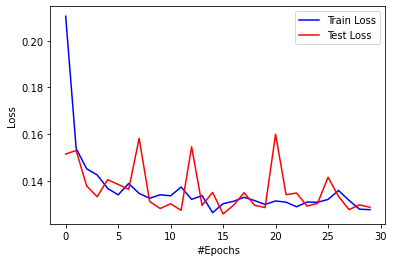

In [23]:
# Training params
num_epochs = 30
print_interval = 5
learning_rate = 0.001
batch_size = 100

# Since all MNIST images are 28x28
image_w = 28
image_h = 28

#Create model
predModel = LinearClassifier(image_w, image_h, 1)

#Set optimizer and loss function
model = predModel;
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) #or torch.optim.SGD
loss_function = SigmoidLoss #torch.nn.MSELoss() #Try the built-in MSELoss, it should be identical

#Load data, split it into batches
training_generator = torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
testing_generator = torch.utils.data.DataLoader(testing_dataset, batch_size=batch_size) 

print("Loaded Data")

trainAndGraph(model, training_generator, testing_generator, loss_function, optimizer, num_epochs, learning_rate, print_interval)

In [24]:
computeLabelAccuracy(model, training_generator, "Test Set")
computeLabelAccuracy(model, testing_generator, "Train Set")


Test Set: Accuracy: 52382/60000 (87.3%)

Train Set: Accuracy: 8712/10000 (87.1%)


### Visualize images predicted and actual labels 

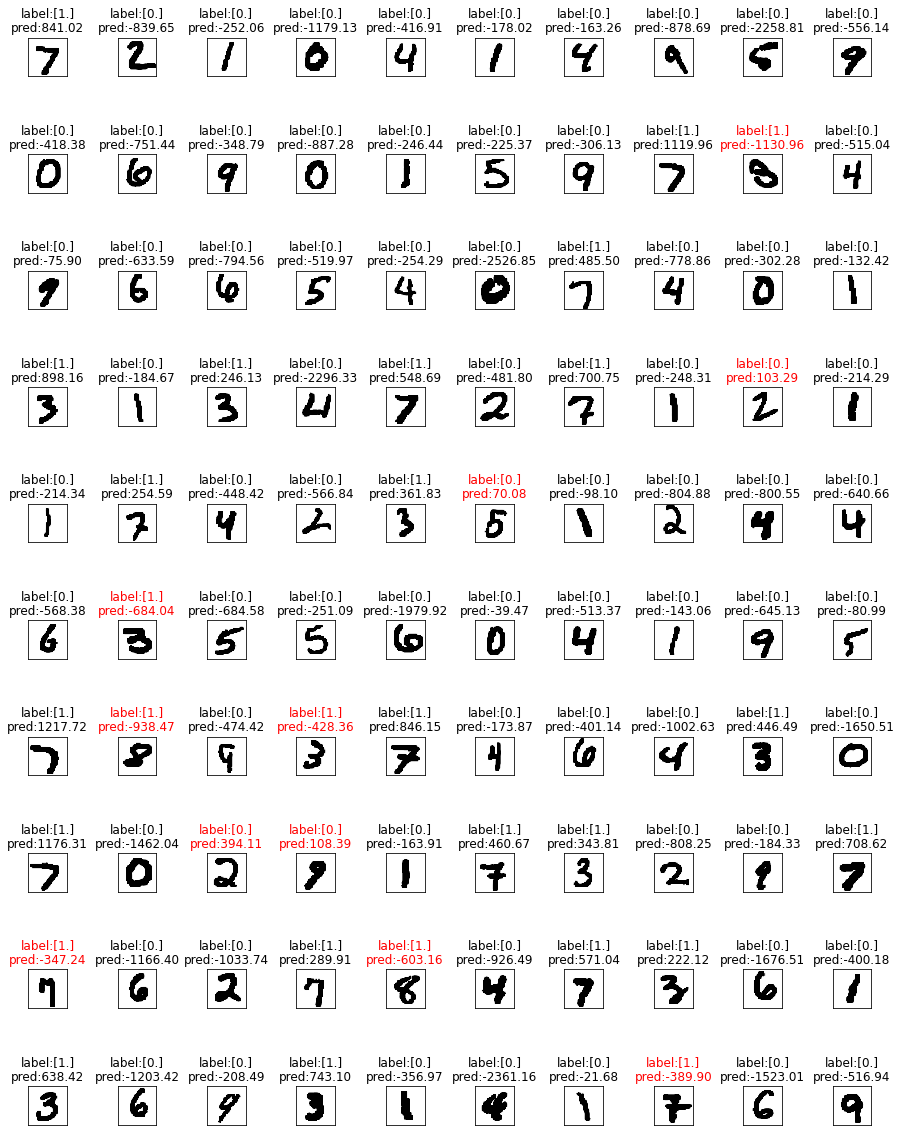

In [25]:
plot_digits_with_predictions(model,mnist_testing_data,three_seven_eight_testing)

### Display classifcation metrics, plot ROC curve

AUC: 0.9020382883653328
Precision [0.8877551  0.82528302]
Recall [0.93374356 0.72609562]
F1 [0.91016878 0.77251854]
Count [6988 3012]


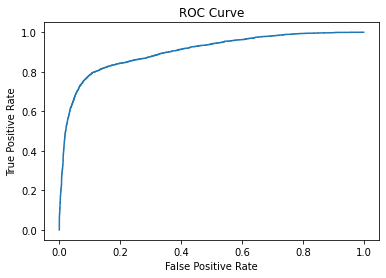

In [26]:
preds = model(torch.tensor(mnist_testing_data).float()).detach().numpy()
fpr, tpr, thresholds = metrics.roc_curve(three_seven_eight_testing,preds)
plt.plot(fpr,tpr)
plt.title("ROC Curve")
print("AUC:",metrics.auc(fpr, tpr))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
p,r,f,count = metrics.precision_recall_fscore_support(three_seven_eight_testing,preds>0)
print("Precision",p)
print("Recall",r)
print("F1",f)
print("Count",count)

### Seeing how accurate KNN is on the data

In [27]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score, auc

# Set X and y
X, y = mnist["data"], mnist["target"]

# Preprocess the dataset
X = X / 255.0  # Scale the data to the range [0, 1]

# Create binary labels
three_seven_eight = ['3', '7', '8']
y_binary = np.isin(y, lucky_numbers).astype(int)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.2, random_state=42)

# Training
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

# Evaluation
y_pred = knn.predict(X_test)

# Print classification report
print(classification_report(y_test, y_pred))

# Print confusion matrix
print(confusion_matrix(y_test, y_pred))

# Print accuracy score
print("Accuracy:", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      9707
           1       0.98      0.97      0.98      4293

    accuracy                           0.99     14000
   macro avg       0.99      0.98      0.98     14000
weighted avg       0.99      0.99      0.99     14000

[[9643   64]
 [ 139 4154]]
Accuracy: 0.9855


AUC: 0.9945120903406209
AUC-ROC: 0.9945120903406209


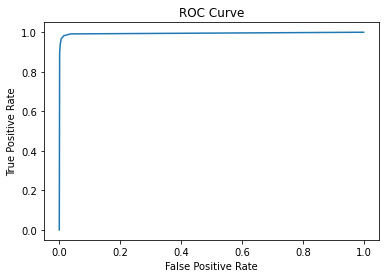

In [29]:
from sklearn.metrics import roc_curve, roc_auc_score, auc

# Get class probabilities for the test set
y_prob = knn.predict_proba(X_test)[:, 1]

# Calculate the ROC curve and AUC-ROC score
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.plot(fpr,tpr)
plt.title("ROC Curve")
print("AUC:",auc(fpr, tpr))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

#### **KNN alone outperformed the linear regression method we had tried earlier by 8-9% on the data**

## Setup & Train Multi-Layer Perceptron as Classifier

In [35]:
X = mnist["data"]
y = mnist["target"]

# Preprocess dataset
X = X / 255.0  # Scale the data to the range [0, 1]
y = y.astype(int)  # Convert the labels from strings to integers

X = X.to_numpy()
y = y.to_numpy()

# Split data into training & testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [36]:
# Convert numpy arrays to tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

# Declare MLP
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(-1, 28 * 28)  # Flatten the input
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)  # No activation for the last layer
        return x

# Set hyperparameters (crossentropyloss, learning rate, momentum)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLP().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
num_epochs = 10
batch_size = 100

# Train model
model.train()
num_batches = len(X_train) // batch_size
for epoch in range(num_epochs):
    for batch_idx in range(num_batches):
        start = batch_idx * batch_size
        end = start + batch_size
        data, target = X_train[start:end].to(device), y_train[start:end].to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}")

# Evaluate
model.eval()
output_test = model(X_test.to(device))
_, predicted = torch.max(output_test.data, 1)
correct = (predicted == y_test.to(device)).sum().item()
accuracy = correct / len(y_test) * 100
print(f"Accuracy: {accuracy:.2f}%")

Epoch 1/10, Loss: 0.33169224858283997
Epoch 2/10, Loss: 0.18269082903862
Epoch 3/10, Loss: 0.1271975338459015
Epoch 4/10, Loss: 0.10681717842817307
Epoch 5/10, Loss: 0.08956065773963928
Epoch 6/10, Loss: 0.07669489085674286
Epoch 7/10, Loss: 0.06847494840621948
Epoch 8/10, Loss: 0.06725649535655975
Epoch 9/10, Loss: 0.062036968767642975
Epoch 10/10, Loss: 0.0565279945731163
Accuracy: 96.99%


Scaled the image data as with the KNN model in order to increase efficiency of the model. For this multi-layer neural network, I had one input layer, two hidden layers, and an output layer. The input layer is of size 784, corresponding to the 28x28 pixels of the images. The first hidden layer is of size 128. I found that this size helps balance efficiency and computation power, allowing for the model to be quick but still have effective output. The second hidden layer is of size 64. This is to reduce the dimensionality of the problem in this layer. The output layer is of size 10, corresponding to the 10 classes in this dataset, one for each digit. This multi-layer perceptron had an accuracy of around 97%, very close to that of the KNN model.

### Run on test data, visualize model's most confident answer for each digit

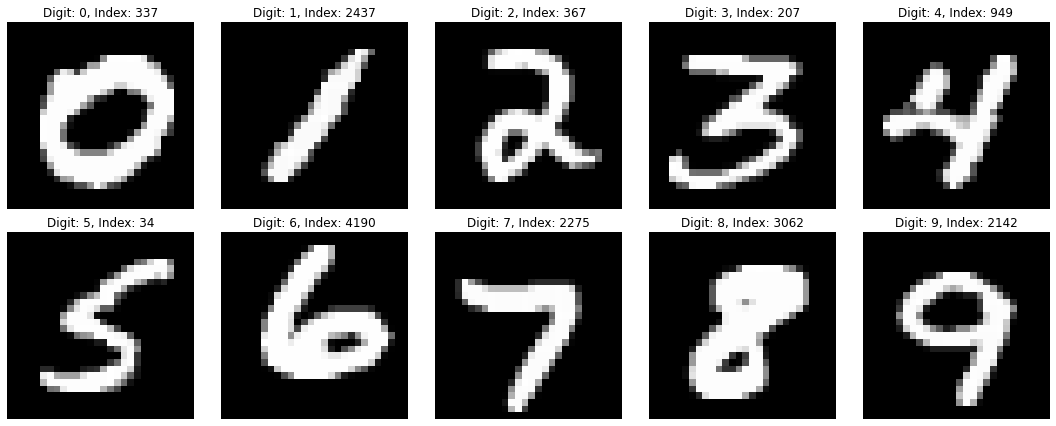

In [37]:
# Run the model on the test dataset
output_test = model(X_test.to(device))
predicted_probs = nn.functional.softmax(output_test, dim=1)  # Compute predicted probabilities
predicted_probs_np = predicted_probs.cpu().detach().numpy()  # Convert to NumPy array

# Initialize an empty list to store the indices of the most confident images
most_confident_indices = []

# Find the index of the highest probability for each digit class
for digit in range(10):
    digit_probs = predicted_probs_np[:, digit]
    most_confident_index = np.argmax(digit_probs)
    most_confident_indices.append(most_confident_index)

# Visualize the most confident images for each digit class
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.ravel()

for i, index in enumerate(most_confident_indices):
    img = X_test[index].reshape(28, 28)
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(f"Digit: {i}, Index: {index}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

### Display a confusion matrix and examples of the five most frequently misclassified digits

Confusion Matrix:
[[1304    1    7    0    2    3   17    2    5    2]
 [   0 1579    7    3    1    0    2    4    4    0]
 [   0    4 1356    4    3    1    4    2    4    2]
 [   0    3   18 1377    2   15    1    7    5    5]
 [   0    1    5    0 1267    1    5    2    1   13]
 [   0    1    1   12    3 1237   11    1    6    1]
 [   2    1    2    0    7    7 1376    0    1    0]
 [   1    7   20    4    5    1    1 1449    2   13]
 [   4    9   12   12    4    9    9    2 1288    8]
 [   4    7    2    7   30    4    0   10   10 1346]]

Five Most Common Misclassifications:
9 misclassified as 4: 30 times
7 misclassified as 2: 20 times
3 misclassified as 2: 18 times
0 misclassified as 6: 17 times
3 misclassified as 5: 15 times


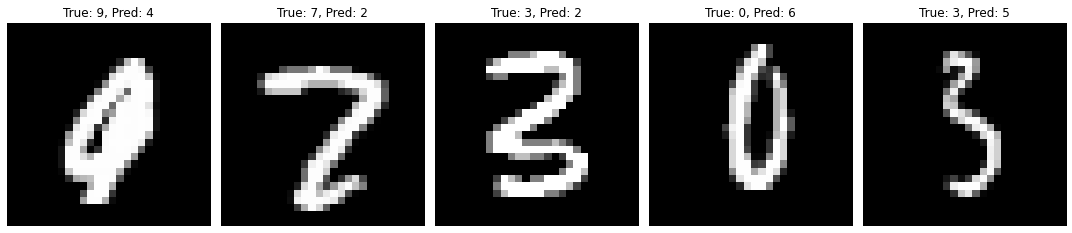

In [45]:
# Compute the confusion matrix
true_labels = y_test.cpu().numpy()
predicted_labels = predicted.cpu().numpy()
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("Confusion Matrix:")
print(conf_matrix)

# Find the five most common misclassifications
misclassifications = []
for i in range(10):
    for j in range(10):
        if i != j:
            misclassifications.append(((i, j), conf_matrix[i, j]))

misclassifications.sort(key=lambda x: x[1], reverse=True)
# Get top 5 misclassifications
most_common_misclassifications = misclassifications[:5]

print("\nFive Most Common Misclassifications:")
for pair, count in most_common_misclassifications:
    print(f"{pair[0]} misclassified as {pair[1]}: {count} times")

# Get examples for the five most common misclassifications
fig, axes = plt.subplots(1, 5, figsize=(15, 6))
axes = axes.ravel()

for i, misclass in enumerate(most_common_misclassifications):
    true_digit, pred_digit = misclass[0]
    misclassified_indices = np.where((true_labels == true_digit) & (predicted_labels == pred_digit))[0]
    example_index = misclassified_indices[0]
    img = X_test[example_index].reshape(28, 28)
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(f"True: {true_digit}, Pred: {pred_digit}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

## Conclusion:

#### Here I tried a variety of classification methods on the MNIST dataset and showed my results both numerically and visually. The Linear classifier had trouble labeling images, while the multi-layer perceptron as well as KNN with k=5 performed quite well at the task of classification.